# Cas de prédiction du Loto français 

In [1]:
#Import des librairies utiles
from bs4 import BeautifulSoup
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, RepeatVector, Flatten
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## Fonction de scraping des tirages

In [2]:
#fonction de scraping des tirages du loto
def scrap_loto_numbers():
    my_list=[]
    time.sleep(2)
    loto_url = "http://loto.akroweb.fr/loto-historique-tirages/"
    page = requests.get(loto_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    body = soup.find('table')
    tirage_line = body.find_all('tr')
    for value in tirage_line:
        my_dict = {}
        res = value.text.split('\n')
        my_dict['day']=res[2]
        my_dict['month_year']=res[3]

        for i,val in enumerate(res[5:10]):
            my_dict['num'+str(i)]=int(val)
        my_dict['chance']=int(res[10])
        my_list.append(my_dict)


    df=pd.DataFrame(my_list)
    return df

In [3]:
#A noter que plusieurs tirages se sont ajoutés dépuis le 21 : date de rédaction de l'article

In [4]:
#sracping des tirages actuellement disponibles sur le site 
df_tirage=scrap_loto_numbers()
df_tirage[['day','month_year','num0','num1','num2','num3','num4','chance']].head()
#suppression  des tirages du super loto( A explorer later )
#df_tirage=df_tirage[(df_tirage['day']!='Vendredi') & (df_tirage['day']!='Mardi')]

,day,month_year,num0,num1,num2,num3,num4,chance
0,Mercredi,09 decembre 2020,17,24,39,47,48,7
1,Lundi,07 decembre 2020,4,27,38,45,48,4
2,Samedi,05 decembre 2020,9,14,20,34,35,1
3,Mercredi,02 decembre 2020,14,23,27,40,46,1
4,Lundi,30 novembre 2020,9,18,26,28,29,3


In [5]:
#df_tirage=df_tirage.tail(df_tirage.shape[0]-1)

## commentaires: 
* le dernier tirage ici date du 07 décembre, ainsi afin de tester le modèle nous allons rétirer ce tirage du dataset dans la suite
* Par contre on aurait évité de supprimer le tirage du 28 si on voulait prédire le prochain tirage ( celui du samedi 31)

In [6]:
#df_tirage=df_tirage.tail(df_tirage.shape[0])# suppression du dernier tirage/à éviter selon le cas 
df_tirage.head()# le dernier tirage devient ici celui du 26

,chance,day,month_year,num0,num1,num2,num3,num4
0,7,Mercredi,09 decembre 2020,17,24,39,47,48
1,4,Lundi,07 decembre 2020,4,27,38,45,48
2,1,Samedi,05 decembre 2020,9,14,20,34,35
3,1,Mercredi,02 decembre 2020,14,23,27,40,46
4,3,Lundi,30 novembre 2020,9,18,26,28,29


## Traitement  des données

In [7]:
df = df_tirage.iloc[::-1]#inversion du dataframe pour placer le dernier tirage en dernière position
df = df[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']]#sélection des numéros à  traiter

In [8]:
df.tail()# notre tirage du 26 ici devient le dernier de notre dataset afin de pourvoir organiser les data par historique

,num0,num1,num2,num3,num4,chance
4,9,18,26,28,29,3
3,14,23,27,40,46,1
2,9,14,20,34,35,1
1,4,27,38,45,48,4
0,17,24,39,47,48,7


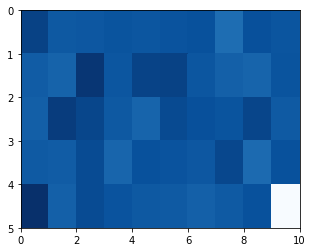

In [9]:


#fonction de vérification de nombres en dessous d'une certaine valeur pour les 5 premiers numéros, sauf celui de chance
def is_under(data, number):
    return ((data['num0'] <= number).astype(int) + 
            (data['num1'] <= number).astype(int) +
            (data['num2'] <= number).astype(int) +
            (data['num3'] <= number).astype(int) +
            (data['num4'] <= number).astype(int))

#fonction de vérification de nombres pairs pour les 5 premiers numéros sauf celui de chance
def is_pair(data):
    return ((data['num0'].isin(pairs)).astype(int) + 
            (data['num1'].isin(pairs)).astype(int) +
            (data['num2'].isin(pairs)).astype(int) +
            (data['num3'].isin(pairs)).astype(int) +
            (data['num4'].isin(pairs)).astype(int))

#fonction de vérification de nombres impairs pour les 5 premiers numéros sauf celui de chance
def is_impair(data):
    return ((data['num0'].isin(impairs)).astype(int) + 
            (data['num1'].isin(impairs)).astype(int) +
            (data['num2'].isin(impairs)).astype(int) +
            (data['num3'].isin(impairs)).astype(int) +
            (data['num4'].isin(impairs)).astype(int))

#fonction de vérification de nombres pairs pour le numéro de chance
def is_pair_etoile(data):
    return (data['chance'].isin(pairs)).astype(int)

#fonction de vérification de nombres impairs pour le numéro de chance
def is_impair_etoile(data):
    return (data['chance'].isin(impairs)).astype(int)

#liste de nombres pairs et impairs
pairs = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
impairs = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]

#Fonction de calcul de la somme de la différence au carré des 5 premiers numéros, sauf celui de chance
def sum_diff(data):
    return ((data['num1'] - data['num0'])**2 + 
            (data['num2'] - data['num1'])**2 +
            (data['num3'] - data['num2'])**2 +
            (data['num4'] - data['num3'])**2)


# Calcul de la fréquence de tirage de chaque numéro
freqs = []
for val in range(50):
    count = ( (df['num0'] == val+1).sum() +
              (df['num1'] == val+1).sum() +
              (df['num2'] == val+1).sum() +
              (df['num3'] == val+1).sum() +
              (df['num4'] == val+1).sum() )
    freqs.append(count)
ax = plt.gca() ;  ax.invert_yaxis()
plt.gcf().set_size_inches(5, 4)
heatmap = plt.pcolor(np.reshape(np.array(freqs), (5, 10)), cmap=plt.cm.Blues)

def freq_val(data, column):
    tab = data[column].values.tolist()
    freqs = []
    pos = 1
    for e in tab:
        freqs.append(tab[0:pos].count(e))
        pos = pos + 1
    return freqs



#df['sum'] = ((df.num0 + df.num1 + df.num2 + df.num3 + df.num4 + df.chance ) >185).astype(int)


In [10]:
#ajout de la difference entre les numéros(A explorer ASAp)
#for i in range(4):
    #print(i,i+1)
    #df['diff_{}'.format(i)]=df['num{}'.format(i+1)]-df['num{}'.format(i)]
#application des fonctions sur le dataframe
df['freq_num0'] = freq_val(df, 'num0')
df['freq_num1'] = freq_val(df, 'num1')
df['freq_num2'] = freq_val(df, 'num2')
df['freq_num3'] = freq_val(df, 'num3')
df['freq_num4'] = freq_val(df, 'num4')
df['freq_chance'] = freq_val(df, 'chance')#calcul des frequences 
df['sum_diff'] = sum_diff(df)#somme de la différence au carré entre chaque couple de numéros successifs dans le tirage
df['pair_chance'] = is_pair_etoile(df)
df['impair_chance'] = is_impair_etoile(df)
df['pair'] = is_pair(df)
df['impair'] = is_impair(df)#verification de nombre pair et impair
df['is_under_24'] = is_under(df, 24)  # Les numeros en dessous de 24 
df['is_under_40'] = is_under(df, 40)# Les numeros en dessous de 40 
df.head(6)

,num0,num1,num2,num3,num4,chance,freq_num0,freq_num1,freq_num2,freq_num3,freq_num4,freq_chance,sum_diff,pair_chance,impair_chance,pair,impair,is_under_24,is_under_40
1942,19,24,27,33,41,9,1,1,1,1,1,1,134,0,1,1,4,2,4
1941,22,24,32,41,48,1,1,2,1,1,1,1,198,0,1,4,1,2,3
1940,10,20,22,39,46,4,1,1,1,1,1,1,442,1,0,4,1,3,4
1939,10,11,37,41,48,4,2,1,1,2,2,2,742,1,0,2,3,2,3
1938,18,20,28,40,49,1,1,2,1,1,1,2,293,0,1,4,1,2,4
1937,4,32,35,39,44,10,1,1,1,2,1,1,834,1,0,3,2,1,4


## Modèle et fonction de formatage des données en entrée du LSTM

In [11]:
#capture 3: fonction define model seulement

In [12]:
# j'ai ici défini plusieurs modèles à tester mais pour l'intant je tavaille avec le lstm(fonction : define_model)
# j'ai ici défini window_length à 12 pour apprendre sur 1 mois de données 

#Params du modèle
nb_label_feature=6

UNITS = 100
BATCHSIZE = 30
EPOCH = 1500
#ACTIVATION = "softmax"
OPTIMIZER ='adam' # rmsprop, adam, sgd
LOSS = 'mae'#'categorical_crossentropy' #mse
DROPOUT = 0.1
window_length =12 #12 
number_of_features = df.shape[1]

#Architecture du modèle
def define_model(number_of_features,nb_label_feature):
    #initialisation du rnn
    model = Sequential()
    #ajout de la premiere couche lstm
    model.add(LSTM(UNITS, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(UNITS, dropout=0.1, return_sequences=False))
    #ajout de la couche de sortie
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_bidirectionnel_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, return_sequences=True), input_shape=(window_length, number_of_features)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(100, dropout=0.1))
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_autoencoder_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(LSTM(100, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(RepeatVector(window_length))
    model.add(LSTM(100, dropout=0.1, return_sequences=True))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(number_of_features)))
    model.add(Flatten())
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model



#model = define_model(number_of_features,nb_label_feature)
#model3 = define_autoencoder_model(number_of_features,nb_label_feature)
#model4 = define_bidirectionnel_model(number_of_features,nb_label_feature)

#Moniteur pour stoper le training
es = EarlyStopping(monitor='acc', mode='max', verbose=1, patience=100)

In [13]:
# Fonction de formatage des données en entrée du LSTM
def create_lstm_dataset(df, window_length,nb_label_feature):
    number_of_rows = df.shape[0]   #taille du dataset number_of_features
    number_of_features = df.shape[1]
    scaler = StandardScaler().fit(df.values)
    transformed_dataset = scaler.transform(df.values)
    transformed_df = pd.DataFrame(data=transformed_dataset, index=df.index)
    #tableau de tableau de taille(number_of_rows-window_length) et window_length ligne,number_of_features
    #lstm:[nb total de row ,nb de ligne dans le passé, nb de colonne(feature)]
    train = np.empty([number_of_rows-window_length, window_length, number_of_features], dtype=float)
    
    label = np.empty([number_of_rows-window_length, nb_label_feature], dtype=float)
    for i in range(0, number_of_rows-window_length):
        train[i] = transformed_df.iloc[i:i+window_length, 0: number_of_features]
        label[i] = transformed_df.iloc[i+window_length: i+window_length+1, 0:nb_label_feature]
        
    #définition du modèle Lstm  
    model = define_model(number_of_features,nb_label_feature)
        
    return train, label, model,scaler

## Training

In [14]:
#formatage des données
train, label,model,scaler1 = create_lstm_dataset(df, window_length,nb_label_feature)
print(train.shape)
print(label.shape)
 

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(1931, 12, 19)
(1931, 6)


* On voit ici que notre dataset d'entrainement après formatage est constitué de 1911 vecteurs contenant chacun 12 tirages où chaque tirage contient 19 features calculés plus haut

* Quant aux labels, on a bien 1911 vecteurs de 6 features soit les 6 numéros de chaque tirages

* Ainsi à partir des 12 tirages précédent on éssaie de prédire le tirage suivant lors de l'entrainement

In [15]:
#Training
history=model.fit(train, label, batch_size=BATCHSIZE, epochs=EPOCH, verbose=2, callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1500
 - 3s - loss: 0.8123 - acc: 0.1559
Epoch 2/1500
 - 2s - loss: 0.8069 - acc: 0.1491
Epoch 3/1500
 - 2s - loss: 0.8049 - acc: 0.1543
Epoch 4/1500
 - 2s - loss: 0.8037 - acc: 0.1611
Epoch 5/1500
 - 2s - loss: 0.8018 - acc: 0.1579
Epoch 6/1500
 - 2s - loss: 0.7998 - acc: 0.1776
Epoch 7/1500
 - 2s - loss: 0.7963 - acc: 0.1756
Epoch 8/1500
 - 2s - loss: 0.7920 - acc: 0.1838
Epoch 9/1500
 - 2s - loss: 0.7862 - acc: 0.1844
Epoch 10/1500
 - 2s - loss: 0.7805 - acc: 0.2025
Epoch 11/1500
 - 2s - loss: 0.7718 - acc: 0.1864
Epoch 12/1500
 - 2s - loss: 0.7641 - acc: 0.2092
Epoch 13/1500
 - 2s - loss: 0.7574 - acc: 0.2227
Epoch 14/1500
 - 2s - loss: 0.7463 - acc: 0.2351
Epoch 15/1500
 - 2s - loss: 0.7313 - acc: 0.2563
Epoch 16/1500
 - 2s - loss: 0.7163 - acc: 0.2553
Epoch 17/1500
 - 2s - loss: 0.7026 - acc: 0.2600
Epoch 18/1500
 - 1s - loss: 0.6853 - acc: 0.2931
Epoch 19/1500
 - 2s - loss: 0.6689 - acc: 0.3035
Epoch 20/1500
 - 2s - loss: 0.

Epoch 162/1500
 - 1s - loss: 0.1452 - acc: 0.8597
Epoch 163/1500
 - 2s - loss: 0.1411 - acc: 0.8705
Epoch 164/1500
 - 2s - loss: 0.1437 - acc: 0.8509
Epoch 165/1500
 - 2s - loss: 0.1421 - acc: 0.8612
Epoch 166/1500
 - 2s - loss: 0.1436 - acc: 0.8602
Epoch 167/1500
 - 2s - loss: 0.1416 - acc: 0.8628
Epoch 168/1500
 - 2s - loss: 0.1399 - acc: 0.8560
Epoch 169/1500
 - 2s - loss: 0.1409 - acc: 0.8586
Epoch 170/1500
 - 2s - loss: 0.1395 - acc: 0.8664
Epoch 171/1500
 - 2s - loss: 0.1397 - acc: 0.8581
Epoch 172/1500
 - 2s - loss: 0.1425 - acc: 0.8617
Epoch 173/1500
 - 2s - loss: 0.1371 - acc: 0.8607
Epoch 174/1500
 - 2s - loss: 0.1389 - acc: 0.8472
Epoch 175/1500
 - 2s - loss: 0.1412 - acc: 0.8633
Epoch 176/1500
 - 2s - loss: 0.1396 - acc: 0.8643
Epoch 177/1500
 - 2s - loss: 0.1383 - acc: 0.8674
Epoch 178/1500
 - 2s - loss: 0.1380 - acc: 0.8711
Epoch 179/1500
 - 2s - loss: 0.1389 - acc: 0.8716
Epoch 180/1500
 - 2s - loss: 0.1379 - acc: 0.8597
Epoch 181/1500
 - 2s - loss: 0.1353 - acc: 0.8731


Epoch 326/1500
 - 2s - loss: 0.1082 - acc: 0.8990
Epoch 327/1500
 - 2s - loss: 0.1091 - acc: 0.8871
Epoch 328/1500
 - 2s - loss: 0.1086 - acc: 0.8985
Epoch 329/1500
 - 2s - loss: 0.1104 - acc: 0.8980
Epoch 330/1500
 - 2s - loss: 0.1093 - acc: 0.8835
Epoch 331/1500
 - 2s - loss: 0.1085 - acc: 0.8949
Epoch 332/1500
 - 2s - loss: 0.1088 - acc: 0.8840
Epoch 333/1500
 - 2s - loss: 0.1089 - acc: 0.8902
Epoch 334/1500
 - 2s - loss: 0.1085 - acc: 0.8959
Epoch 335/1500
 - 2s - loss: 0.1095 - acc: 0.8980
Epoch 336/1500
 - 2s - loss: 0.1098 - acc: 0.8814
Epoch 337/1500
 - 2s - loss: 0.1078 - acc: 0.9001
Epoch 338/1500
 - 2s - loss: 0.1077 - acc: 0.8949
Epoch 339/1500
 - 2s - loss: 0.1066 - acc: 0.9037
Epoch 340/1500
 - 2s - loss: 0.1075 - acc: 0.8933
Epoch 341/1500
 - 2s - loss: 0.1080 - acc: 0.8788
Epoch 342/1500
 - 2s - loss: 0.1084 - acc: 0.8938
Epoch 343/1500
 - 2s - loss: 0.1057 - acc: 0.8902
Epoch 344/1500
 - 2s - loss: 0.1076 - acc: 0.8887
Epoch 345/1500
 - 2s - loss: 0.1078 - acc: 0.8824


Epoch 490/1500
 - 2s - loss: 0.0961 - acc: 0.9047
Epoch 491/1500
 - 2s - loss: 0.0955 - acc: 0.9073
Epoch 492/1500
 - 2s - loss: 0.0936 - acc: 0.9016
Epoch 493/1500
 - 2s - loss: 0.0952 - acc: 0.9099
Epoch 494/1500
 - 2s - loss: 0.0944 - acc: 0.9125
Epoch 495/1500
 - 2s - loss: 0.0946 - acc: 0.9099
Epoch 496/1500
 - 2s - loss: 0.0927 - acc: 0.9016
Epoch 497/1500
 - 3s - loss: 0.0945 - acc: 0.8964
Epoch 498/1500
 - 3s - loss: 0.0947 - acc: 0.9016
Epoch 499/1500
 - 2s - loss: 0.0947 - acc: 0.9104
Epoch 500/1500
 - 2s - loss: 0.0943 - acc: 0.9021
Epoch 501/1500
 - 2s - loss: 0.0929 - acc: 0.9120
Epoch 502/1500
 - 2s - loss: 0.0923 - acc: 0.9078
Epoch 503/1500
 - 2s - loss: 0.0942 - acc: 0.9057
Epoch 504/1500
 - 2s - loss: 0.0941 - acc: 0.9047
Epoch 505/1500
 - 2s - loss: 0.0936 - acc: 0.9151
Epoch 506/1500
 - 2s - loss: 0.0944 - acc: 0.8980
Epoch 507/1500
 - 2s - loss: 0.0960 - acc: 0.9094
Epoch 508/1500
 - 2s - loss: 0.0932 - acc: 0.8959
Epoch 509/1500
 - 2s - loss: 0.0947 - acc: 0.9078


Epoch 654/1500
 - 2s - loss: 0.0865 - acc: 0.9089
Epoch 655/1500
 - 2s - loss: 0.0867 - acc: 0.9104
Epoch 656/1500
 - 2s - loss: 0.0880 - acc: 0.9109
Epoch 657/1500
 - 2s - loss: 0.0845 - acc: 0.9166
Epoch 658/1500
 - 2s - loss: 0.0852 - acc: 0.9197
Epoch 659/1500
 - 2s - loss: 0.0859 - acc: 0.9208
Epoch 660/1500
 - 2s - loss: 0.0853 - acc: 0.9032
Epoch 661/1500
 - 1s - loss: 0.0844 - acc: 0.9104
Epoch 662/1500
 - 2s - loss: 0.0854 - acc: 0.9156
Epoch 663/1500
 - 2s - loss: 0.0856 - acc: 0.9202
Epoch 664/1500
 - 2s - loss: 0.0859 - acc: 0.9057
Epoch 665/1500
 - 2s - loss: 0.0853 - acc: 0.9083
Epoch 666/1500
 - 2s - loss: 0.0857 - acc: 0.9073
Epoch 667/1500
 - 2s - loss: 0.0851 - acc: 0.9073
Epoch 668/1500
 - 2s - loss: 0.0866 - acc: 0.9177
Epoch 669/1500
 - 2s - loss: 0.0859 - acc: 0.9063
Epoch 670/1500
 - 2s - loss: 0.0882 - acc: 0.9202
Epoch 671/1500
 - 2s - loss: 0.0833 - acc: 0.9114
Epoch 672/1500
 - 2s - loss: 0.0844 - acc: 0.9316
Epoch 673/1500
 - 2s - loss: 0.0862 - acc: 0.9083


## Fonction de perte 

In [ ]:
#capture 6

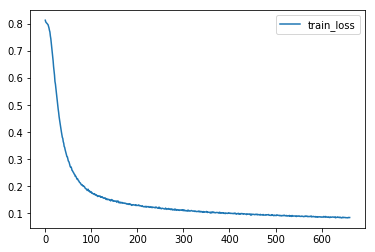

In [78]:
plt.plot(history.history['loss'])
plt.legend(['train_loss'])
plt.show()

## Prédiction du tirage suivant le dernier tirage de notre dataset de train

In [16]:
#Prediction basée sur les 12 derniers tirages
last_twelve = df.tail(window_length) # on recupere les 12 derniers tirages
scaler = StandardScaler().fit(df.values)
scaled_to_predict = scaler.transform(last_twelve)
scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [17]:
#prediction
tom = df.tail(window_length).iloc[:,0:6] # 
scaler = StandardScaler().fit(df.iloc[:,0:6])
scaled_to_predict = scaler.transform(tom)
print(scaler.inverse_transform(scaled_predicted_output_1).astype(int)[0])

[ 9 15 21 31 39  4]


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
